<a href="https://colab.research.google.com/github/richardggx94/Mindbody-Assignment/blob/main/Mindbody_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Diff-in-diff Promotion Impact on Demand (Purchases), Class Awareness (Pack Views) and Conversion Rate (Purchases/View)**

In [37]:
# -*- coding: utf-8 -*-
"""
Analysis of a Pricing Test using a Difference-in-Differences (DiD) approach.

This script performs the following steps:
1.  Loads and preprocesses experimental data from an Excel file.
2.  For key outcome metrics (Purchases, Pack Views, Conversion Rate), it:
    a. Runs a DiD regression analysis to estimate the causal impact of a 15% price
       promotion on user behavior. Clustered standard errors are used to account
       for repeated observations per company.
    b. Calculates the implied price elasticity using a log-log DiD formulation.
    c. Uses the calculated elasticity to project the potential DiD impact of a
       hypothetical 25% price promotion.
3.  Prints a formatted summary of the results for each metric.
"""

# === 1. Imports and Configuration ===

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from typing import Dict, Any, Tuple, List

# --- Configuration ---
# By defining constants here, the script is easier to configure and maintain.
FILE_PATH: str = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
OUTCOME_METRICS: List[str] = ['Purchases', 'Pack Views', 'conversion']
CLUSTER_ID: str = 'Company ID'
ALPHA: float = 0.05  # Significance level for confidence intervals and power analysis.


# === 2. Data Loading and Preprocessing ===

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from the specified Excel file and creates variables for DiD analysis.

    Args:
        file_path (str): The path to the input Excel file.

    Returns:
        pd.DataFrame: A DataFrame with added columns for the analysis.
    """
    try:
        # The sheet name is inferred from the original file upload.
        df = pd.read_excel(file_path, sheet_name='Raw Data')
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")
        return pd.DataFrame()


    # Create dummy variables required for the DiD regression model.
    # 'treated': 1 if the company is in the Test cohort, 0 otherwise.
    df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
    # 'post': 1 if the observation is from the Post-treatment period, 0 otherwise.
    df['post'] = (df['Period'] == 'Post').astype(int)
    # 'did': The interaction term (treated * post), which captures the DiD effect.
    df['did'] = df['treated'] * df['post']

    # --- Conversion Rate ---
    # Calculate conversion rate as Purchases per Pack View.
    # We must handle the case where 'Pack Views' is zero to avoid division by zero.
    # We replace infinite values with NaN and then fill NaNs with 0. This assumes that
    # zero pack views logically results in a zero conversion rate.
    df['conversion'] = df['Purchases'] / df['Pack Views']
    df['conversion'] = df['conversion'].replace([np.inf, -np.inf], np.nan).fillna(0)

    return df


# === 3. Core Analysis Functions ===

def run_did_analysis(df: pd.DataFrame, outcome_var: str) -> Dict[str, Any]:
    """
    Performs a Difference-in-Differences (DiD) regression and power analysis.

    The power analysis correctly uses the number of unique companies in each
    group (Test and Control) as the sample size.

    Args:
        df (pd.DataFrame): The input DataFrame containing preprocessed data.
        outcome_var (str): The name of the dependent variable for the regression.

    Returns:
        Dict[str, Any]: A dictionary containing key results from the analysis.
    """
    # Define the OLS model formula. The Q() function ensures that variable names
    # with spaces (like 'Pack Views') are handled correctly.
    model_formula = f'Q("{outcome_var}") ~ treated + post + did'

    # Fit the model using Ordinary Least Squares (OLS).
    # We use clustered standard errors at the 'Company ID' level. This is crucial
    # because observations from the same company are not independent, and clustering
    # corrects the standard errors for this intra-group correlation.
    model = smf.ols(model_formula, data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df[CLUSTER_ID]})

    # --- Extract Key Regression Results ---
    did_coefficient = result.params.get('did', np.nan)
    did_se = result.bse.get('did', np.nan)
    p_value = result.pvalues.get('did', np.nan)
    ci_low, ci_high = result.conf_int().loc['did'] if 'did' in result.conf_int().index else (np.nan, np.nan)

    # --- Post-hoc Power Analysis ---
    # Power is calculated based on the number of unique entities (companies)
    # in each group, as these are the independent units of observation.

    # Get the number of unique companies in the test and control groups.
    n_test = df[df['treated'] == 1][CLUSTER_ID].nunique()
    n_control = df[df['treated'] == 0][CLUSTER_ID].nunique()

    # Calculate Cohen's d (standardized effect size) using the overall SD.
    pooled_sd = df[outcome_var].std()
    cohen_d = did_coefficient / pooled_sd if pooled_sd > 0 else 0

    power = np.nan
    # The power calculation requires the sample size of both groups.
    if n_test > 1 and n_control > 1 and not np.isnan(cohen_d):
        power_analysis = TTestIndPower()
        power = power_analysis.power(
            effect_size=cohen_d,
            nobs1=n_test,              # Sample size for the first group (Test)
            alpha=ALPHA,
            ratio=n_control / n_test   # Ratio of sample sizes (Control/Test)
        )

    return {
        'DiD Coefficient': did_coefficient,
        'SE (clustered)': did_se,
        'p-value': p_value,
        '95% CI': (ci_low, ci_high),
        'Cohen_d': cohen_d,
        'Power': power,
        'n_test': n_test,      # Include for transparent reporting
        'n_control': n_control, # Include for transparent reporting
        'result_object': result
    }

def calculate_log_log_elasticity(df: pd.DataFrame, outcome_var: str) -> float:
    """
    Calculates the price elasticity using a log-log DiD formulation.
    Elasticity = (% Change in Quantity) / (% Change in Price)
               ≈ (Δlog(Quantity)) / (Δlog(Price))

    Args:
        df (pd.DataFrame): The input DataFrame.
        outcome_var (str): The "quantity" variable (e.g., 'Purchases').

    Returns:
        float: The calculated price elasticity, or np.nan if not computable.
    """
    means = df.groupby(['treated', 'post']).agg({
        outcome_var: 'mean',
        'Promotion Pack Price': 'mean'
    })

    # Unpack means for clarity. (0=control, 1=test; 0=pre, 1=post)
    ctrl_pre = means.loc[(0, 0)]
    ctrl_post = means.loc[(0, 1)]
    test_pre = means.loc[(1, 0)]
    test_post = means.loc[(1, 1)]

    # Taking the log requires all mean values to be positive.
    if not all(val > 0 for val in means.values.flatten()):
        return np.nan

    dlog_qty = (np.log(test_post[outcome_var]) - np.log(test_pre[outcome_var])) - \
               (np.log(ctrl_post[outcome_var]) - np.log(ctrl_pre[outcome_var]))

    dlog_price = (np.log(test_post['Promotion Pack Price']) - np.log(test_pre['Promotion Pack Price'])) - \
                 (np.log(ctrl_post['Promotion Pack Price']) - np.log(ctrl_pre['Promotion Pack Price']))

    return dlog_qty / dlog_price if dlog_price != 0 else np.nan


def project_impact(df: pd.DataFrame, outcome_var: str, elasticity: float, price_change_pct: float) -> Tuple[float, float]:
    """
    Projects the DiD impact of a new price change using the calculated elasticity.

    Args:
        df (pd.DataFrame): The input DataFrame.
        outcome_var (str): The outcome metric to project.
        elasticity (float): The price elasticity calculated previously.
        price_change_pct (float): The new price change as a percentage (e.g., -0.25).

    Returns:
        A tuple of (projected average outcome, projected DiD effect).
    """
    if pd.isna(elasticity):
        return np.nan, np.nan

    # Establish baseline values from the pre-period for both groups
    test_pre_period = df[(df['treated'] == 1) & (df['post'] == 0)]
    ctrl_pre_period = df[(df['treated'] == 0) & (df['post'] == 0)]
    ctrl_post_period = df[(df['treated'] == 0) & (df['post'] == 1)]

    baseline_price = test_pre_period['Promotion Pack Price'].mean()
    baseline_outcome = test_pre_period[outcome_var].mean()

    # Calculate the underlying trend from the control group
    control_trend = ctrl_post_period[outcome_var].mean() - ctrl_pre_period[outcome_var].mean()

    new_price = baseline_price * (1 + price_change_pct)

    if baseline_price > 0:
        # 1. Project the new outcome level for the test group based on elasticity
        projected_outcome_simple = baseline_outcome * (new_price / baseline_price) ** elasticity

        # 2. The DiD effect is the change in the test group minus the change in the control group
        projected_did_effect = (projected_outcome_simple - baseline_outcome) - control_trend

        # 3. The final projected purchase level is the baseline + control trend + DiD effect
        final_projected_outcome = baseline_outcome + control_trend + projected_did_effect

        return final_projected_outcome, projected_did_effect
    else:
        return np.nan, np.nan


# === 4. Reporting Function ===

def print_results_summary(metric_name: str, did_results: Dict, elasticity: float, projection: Tuple):
    """Prints a formatted summary of all analysis results for a given metric."""
    pred_outcome, pred_did_effect = projection

    print("-" * 60)
    print(f"📊 ANALYSIS SUMMARY FOR: {metric_name.upper()} 📊")
    print("-" * 60)

    print("\n--- 15% Promotion Observed Impact (DiD) ---")
    print(f"  - DiD Coefficient (Causal Effect): {did_results['DiD Coefficient']:.3f}")
    print(f"  - Clustered Standard Error:       {did_results['SE (clustered)']:.3f}")
    print(f"  - P-value:                        {did_results['p-value']:.3f}")
    print(f"  - 95% Confidence Interval:        [{did_results['95% CI'][0]:.3f}, {did_results['95% CI'][1]:.3f}]")

    print("\n--- Power and Sample Size ---")
    n_test = did_results.get('n_test', 'N/A')
    n_control = did_results.get('n_control', 'N/A')
    print(f"  - Effect Size (Cohen's d):        {did_results['Cohen_d']:.3f}")
    print(f"  - Sample Size for Power Calc:     {n_test} Test Cos., {n_control} Control Cos.")
    print(f"  - Statistical Power (Post-hoc):   {did_results['Power']:.3f}")


    print("\n--- Price Elasticity ---")
    if not pd.isna(elasticity):
        print(f"  - Implied Log-Log DiD Elasticity: {elasticity:.3f}")
    else:
        print("  - Implied Log-Log DiD Elasticity: Not computable (non-positive means).")

    print("\n--- 25% Promotion Projected Impact (DiD Adjusted) ---")
    if not pd.isna(pred_outcome):
        print(f"  - Projected Average Outcome:      {pred_outcome:.3f}")
        print(f"  - Projected DiD Effect:           {pred_did_effect:.3f}")
    else:
        print("  - Projection not available (elasticity could not be computed).")
    print("\n")


# === 5. Main Execution Block ===

def main():
    """Main function to run the entire analysis workflow."""
    print("Starting pricing experiment analysis...")

    data = load_and_preprocess_data(FILE_PATH)
    if data.empty:
        print("Analysis stopped due to data loading issues.")
        return

    for metric in OUTCOME_METRICS:
        did_results = run_did_analysis(data, metric)
        elasticity = calculate_log_log_elasticity(data, metric)
        projection_25_pct = project_impact(data, metric, elasticity, price_change_pct=-0.25)
        print_results_summary(metric, did_results, elasticity, projection_25_pct)

    print("Analysis complete.")


if __name__ == '__main__':
    main()

Starting pricing experiment analysis...
------------------------------------------------------------
📊 ANALYSIS SUMMARY FOR: PURCHASES 📊
------------------------------------------------------------

--- 15% Promotion Observed Impact (DiD) ---
  - DiD Coefficient (Causal Effect): 109.010
  - Clustered Standard Error:       10.204
  - P-value:                        0.000
  - 95% Confidence Interval:        [89.010, 129.010]

--- Power and Sample Size ---
  - Effect Size (Cohen's d):        0.338
  - Sample Size for Power Calc:     100 Test Cos., 100 Control Cos.
  - Statistical Power (Post-hoc):   0.661

--- Price Elasticity ---
  - Implied Log-Log DiD Elasticity: -1.224

--- 25% Promotion Projected Impact (DiD Adjusted) ---
  - Projected Average Outcome:      712.699
  - Projected DiD Effect:           214.679


------------------------------------------------------------
📊 ANALYSIS SUMMARY FOR: PACK VIEWS 📊
------------------------------------------------------------

--- 15% Promotio

# **Impact Breakdown by Diff-in-diff Methods and Price Segments**

In [ ]:
"""
Analysis of a Pricing Test: Segmented vs. Aggregate Impact

This script performs a detailed analysis of a pricing experiment by:
1.  Loading and preprocessing experimental data.
2.  Running an aggregate Difference-in-Differences (DiD) analysis to find the
    overall impact of a 15% promotion on purchases.
3.  Performing a segmented DiD analysis using a segment-specific control group
    for the most accurate, granular comparison.
4.  Calculating price elasticity using multiple methods for both aggregate
    and segmented data.
5.  Projecting the potential impact of a hypothetical 25% promotion, including
    a true "bottom-up" segmented projection for both purchases and revenue.
6.  Generating and printing comprehensive summary tables.
"""

# === 1. IMPORTS AND CONFIGURATION ===

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm
from typing import Dict, Any, Tuple

# --- Configuration ---
# Defining constants here makes the script easier to read and modify.
FILE_PATH: str = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
CLUSTER_ID: str = 'Company ID'
PRICE_SEGMENT_COL: str = 'Market Standard Pack Price'
PROMOTION_COL: str = 'Promotion Pack Price'
OUTCOME_VAR: str = 'Purchases'
ALPHA: float = 0.05  # Significance level for p-values and power analysis.

# === 2. DATA LOADING AND HELPER FUNCTIONS ===

def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from the specified Excel file and creates dummy variables
    for the Difference-in-Differences (DiD) analysis.

    Args:
        file_path (str): The path to the input Excel file.

    Returns:
        pd.DataFrame: A DataFrame with added columns for the analysis.
    """
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")
        return pd.DataFrame()

    # Create dummy variables required for the DiD regression model.
    # 'treated': 1 if the company is in the Test cohort, 0 otherwise.
    df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
    # 'post': 1 if the observation is from the Post-treatment period, 0 otherwise.
    df['post'] = (df['Period'] == 'Post').astype(int)
    # 'did': The interaction term (treated * post), which captures the DiD effect.
    df['did'] = df['treated'] * df['post']
    return df

def pval_formatter(p_value: float) -> str:
    """
    Formats a p-value for clean reporting, showing '<0.001' for very small values.
    """
    if pd.isna(p_value):
        return ''
    return '<0.001' if p_value < 0.001 else f"{p_value:.3f}"

# === 3. CORE ANALYSIS FUNCTIONS ===

def run_did_and_power_analysis(df: pd.DataFrame, outcome_var: str) -> Dict[str, Any]:
    """
    Runs a DiD regression with clustered standard errors and a post-hoc power analysis.
    Clustering standard errors by Company ID is crucial because observations for the
    same company across pre and post periods are not independent. This correction
    provides more reliable standard errors. Power is calculated based on the
    number of unique companies in each group.

    Args:
        df (pd.DataFrame): The input data, which can be the full dataset or a segment.
        outcome_var (str): The dependent variable for the regression (e.g., 'Purchases').

    Returns:
        Dict[str, Any]: A dictionary containing key results from the analysis.
    """
    # Check for sufficient variation to run a regression.
    if df['treated'].nunique() < 2 or df['post'].nunique() < 2 or df.empty:
        n_test = df[df['treated'] == 1][CLUSTER_ID].nunique()
        return {
            'did_coefficient': np.nan, 'did_se': np.nan, 'p_value': np.nan,
            'power': np.nan, 'pooled_sd': df[outcome_var].std() if not df.empty else np.nan,
            'n_test': n_test
        }

    # Define and fit the OLS model.
    model = smf.ols(f'Q("{outcome_var}") ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df[CLUSTER_ID]})

    # --- Power Calculation ---
    n_test = df[df['treated'] == 1][CLUSTER_ID].nunique()
    n_control = df[df['treated'] == 0][CLUSTER_ID].nunique()
    ratio = n_control / n_test if n_test > 0 else 1.0 # Handle cases with no test companies in a segment

    pooled_sd = df[outcome_var].std()
    did_coefficient = result.params.get('did', np.nan)
    cohen_d = did_coefficient / pooled_sd if pooled_sd > 0 else 0

    power = np.nan
    if n_test > 0 and n_control > 0 and not np.isnan(cohen_d):
        power_analysis = TTestIndPower()
        power = power_analysis.power(
            effect_size=cohen_d, nobs1=n_test, alpha=ALPHA, ratio=ratio
        )

    return {
        'did_coefficient': did_coefficient,
        'did_se': result.bse.get('did', np.nan),
        'p_value': result.pvalues.get('did', np.nan),
        'power': power,
        'pooled_sd': pooled_sd,
        'n_test': n_test
    }


def calculate_elasticity(df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculates both standard log-log and DiD log-log elasticity.
    The 'df' passed to this function determines the scope (aggregate or segment).

    - Standard Elasticity: Compares pre/post changes for the Test group only.
    - DiD Elasticity: Compares the pre/post change in Test vs. the pre/post change in Control.
                      This isolates the treatment effect from general market trends.

    Args:
        df (pd.DataFrame): The dataset (or segment) to analyze.

    Returns:
        Dict[str, float]: A dictionary with standard and DiD elasticities.
    """
    test_df = df[df['treated'] == 1]
    ctrl_df = df[df['treated'] == 0]

    means = {
        'q_test_pre': test_df[test_df['post'] == 0][OUTCOME_VAR].mean(),
        'p_test_pre': test_df[test_df['post'] == 0][PROMOTION_COL].mean(),
        'q_test_post': test_df[test_df['post'] == 1][OUTCOME_VAR].mean(),
        'p_test_post': test_df[test_df['post'] == 1][PROMOTION_COL].mean(),
        'q_ctrl_pre': ctrl_df[ctrl_df['post'] == 0][OUTCOME_VAR].mean(),
        'q_ctrl_post': ctrl_df[ctrl_df['post'] == 1][OUTCOME_VAR].mean(),
    }

    # Log calculations require all mean values to be positive.
    if not all(pd.notna(v) and v > 0 for v in means.values()):
        return {'elasticity_std': np.nan, 'elasticity_did': np.nan}

    # Elasticity ≈ (% Change in Quantity) / (% Change in Price)
    d_log_q_test = np.log(means['q_test_post'] / means['q_test_pre'])
    d_log_p_test = np.log(means['p_test_post'] / means['p_test_pre'])
    elasticity_std = d_log_q_test / d_log_p_test if d_log_p_test != 0 else np.nan

    d_log_q_ctrl = np.log(means['q_ctrl_post'] / means['q_ctrl_pre'])
    did_d_log_q = d_log_q_test - d_log_q_ctrl
    elasticity_did = did_d_log_q / d_log_p_test if d_log_p_test != 0 else np.nan

    return {'elasticity_std': elasticity_std, 'elasticity_did': elasticity_did}


def run_segmented_analysis(full_df: pd.DataFrame) -> Tuple[pd.DataFrame, float]:
    """
    Runs the full analysis for each price segment using segment-specific controls.
    This "bottom-up" approach calculates results for each segment before aggregating.

    Args:
        full_df (pd.DataFrame): The complete dataset.

    Returns:
        Tuple[pd.DataFrame, float]: A DataFrame with detailed segment results and
                                    the purchase-weighted average elasticity.
    """
    price_tiers = sorted(full_df[PRICE_SEGMENT_COL].unique())
    segment_results = []

    for price in price_tiers:
        seg_df = full_df[full_df[PRICE_SEGMENT_COL] == price].copy()

        # --- DiD Calculation for the Segment ---
        did_results = run_did_and_power_analysis(seg_df, OUTCOME_VAR)
        did_15 = did_results['did_coefficient']
        did_se = did_results['did_se']
        pval = did_results['p_value']

        # --- Power Calculation (Replicating Original Script's Logic) ---
        pre_test_seg = seg_df[(seg_df['Test Cohort'] == 'Test') & (seg_df['Period'] == 'Pre')]
        n_rows_pre_test = pre_test_seg.shape[0]
        cohen_d_15 = did_15 / seg_df[OUTCOME_VAR].std() if seg_df[OUTCOME_VAR].std() > 0 else 0
        power_15 = np.nan
        if n_rows_pre_test > 1 and pd.notna(cohen_d_15):
            # This logic is preserved from the original script for consistency.
            power_15 = TTestIndPower().power(
                effect_size=cohen_d_15, nobs1=n_rows_pre_test // 2, ratio=1.0, alpha=ALPHA
            )

        elasticity = calculate_elasticity(seg_df)

        test_pre = seg_df[(seg_df['treated'] == 1) & (seg_df['post'] == 0)]
        test_post = seg_df[(seg_df['treated'] == 1) & (seg_df['post'] == 1)]

        baseline_purchases = test_pre[OUTCOME_VAR].mean()
        baseline_price = test_pre[PROMOTION_COL].mean()
        observed_purchases_15 = test_post[OUTCOME_VAR].mean()

        # Project purchases for a 25% discount using the segment's DiD elasticity.
        projected_purchases_25 = np.nan
        if pd.notna(elasticity['elasticity_did']) and baseline_price > 0:
            price_25_segment = baseline_price * 0.75
            projected_purchases_25 = baseline_purchases * (price_25_segment / baseline_price) ** elasticity['elasticity_did']

        # Calculate the DiD effect for the 25% projection.
        ctrl_trend = seg_df[seg_df['treated']==0].groupby('post')[OUTCOME_VAR].mean().diff().iloc[-1]
        did_25_proj = (projected_purchases_25 - baseline_purchases) - (ctrl_trend if pd.notna(ctrl_trend) else 0)

        segment_results.append({
            'Segment Price': price,
            'Sample Size': test_pre.shape[0],
            'Elasticity (log-log DiD)': elasticity['elasticity_did'],
            'Baseline Purchases': baseline_purchases,
            'Purchases 15% (Observed)': observed_purchases_15,
            'Purchases 25% (Projected)': projected_purchases_25,
            'DiD 15%': did_15,
            'SE (15%)': did_se,
            'p-value (15%)': pval,
            'Power (15%)': power_15,
            'DiD 25%': did_25_proj,
            '% Increase DiD 15%': (did_15 / baseline_purchases * 100) if baseline_purchases > 0 else 0,
            '% Increase DiD 25%': (did_25_proj / baseline_purchases * 100) if baseline_purchases > 0 else 0,
        })

    results_df = pd.DataFrame(segment_results)
    # Calculate the purchase-weighted average elasticity across all segments.
    valid = results_df.dropna(subset=['Elasticity (log-log DiD)', 'Baseline Purchases'])
    weighted_elasticity = np.average(
        valid['Elasticity (log-log DiD)'], weights=valid['Baseline Purchases']
    ) if not valid.empty else np.nan

    return results_df, weighted_elasticity


def generate_summary_table(df: pd.DataFrame, agg_did: dict, agg_elast: dict, seg_results: pd.DataFrame, seg_elast: float) -> pd.DataFrame:
    """
    Generates the final summary table comparing all aggregate and segmented scenarios.
    This function carefully replicates the calculation logic from the original script.
    """
    # --- Define Baseline and Observed States (Aggregate) ---
    test_pre = df[(df['treated'] == 1) & (df['post'] == 0)]
    test_post = df[(df['treated'] == 1) & (df['post'] == 1)]
    n_obs_agg = test_pre.shape[0]

    b_price_agg = test_pre[PROMOTION_COL].mean()
    b_purch_agg = test_pre[OUTCOME_VAR].mean()
    p15_price_agg = test_post[PROMOTION_COL].mean()
    p15_purch_agg = test_post[OUTCOME_VAR].mean()

    # --- Aggregate Projections for 25% Promo ---
    p25_price_agg = b_price_agg * 0.75
    p25_purch_std = b_purch_agg * (p25_price_agg / b_price_agg) ** agg_elast['elasticity_std'] if pd.notna(agg_elast['elasticity_std']) else np.nan
    p25_purch_did = b_purch_agg * (p25_price_agg / b_price_agg) ** agg_elast['elasticity_did'] if pd.notna(agg_elast['elasticity_did']) else np.nan

    # --- Segmented "Bottom-Up" Projections (Replicating Original Logic) ---
    seg_total_purch_base = (seg_results['Baseline Purchases'] * seg_results['Sample Size']).sum()
    seg_total_purch_25 = (seg_results['Purchases 25% (Projected)'] * seg_results['Sample Size']).sum()
    total_sample_size_seg = seg_results['Sample Size'].sum()

    seg_avg_purch_base = seg_total_purch_base / total_sample_size_seg if total_sample_size_seg > 0 else 0
    seg_avg_purch_25 = seg_total_purch_25 / total_sample_size_seg if total_sample_size_seg > 0 else 0

    seg_total_rev_25 = (seg_results.apply(
        lambda row: row['Purchases 25% (Projected)'] * row['Sample Size'] * (df[(df[PRICE_SEGMENT_COL] == row['Segment Price']) & (df['treated']==1) & (df['post']==0)][PROMOTION_COL].mean() * 0.75),
        axis=1
    )).sum()

    # --- DiD Calculations for 25% Promo Scenarios ---
    ctrl_trend = df[df['treated']==0].groupby('post')[OUTCOME_VAR].mean().diff().iloc[-1]
    did_25_std = (p25_purch_std - b_purch_agg) - ctrl_trend if pd.notna(p25_purch_std) else np.nan
    did_25_did = (p25_purch_did - b_purch_agg) - ctrl_trend if pd.notna(p25_purch_did) else np.nan
    # The DiD for the segmented model compares the change in segmented averages.
    did_25_seg = (seg_avg_purch_25 - seg_avg_purch_base) - ctrl_trend if pd.notna(seg_avg_purch_25) and pd.notna(seg_avg_purch_base) else np.nan

    # --- Projected Stats (SE, p-value, Power) ---
    def get_projected_stats(effect, se_proxy, sd, n):
        if not all(map(pd.notna, [effect, se_proxy, sd, n])) or n == 0 or sd == 0:
            return [np.nan, np.nan, np.nan]
        cohen_d = effect / sd
        power = TTestIndPower().power(effect_size=cohen_d, nobs1=n, ratio=1.0, alpha=ALPHA)
        pval = 2 * (1 - norm.cdf(abs(effect / se_proxy))) if se_proxy > 0 else np.nan
        return [se_proxy, pval, power]

    stats_std = get_projected_stats(did_25_std, agg_did['did_se'], agg_did['pooled_sd'], agg_did['n_test'])
    stats_did = get_projected_stats(did_25_did, agg_did['did_se'], agg_did['pooled_sd'], agg_did['n_test'])
    stats_seg = get_projected_stats(did_25_seg, agg_did['did_se'], agg_did['pooled_sd'], agg_did['n_test'])

    # --- Revenue Calculations (Replicating Original Logic) ---
    # Use precise row-by-row calculation for observed data.
    total_rev_baseline = (test_pre[PROMOTION_COL] * test_pre[OUTCOME_VAR]).sum()
    total_rev_15 = (test_post[PROMOTION_COL] * test_post[OUTCOME_VAR]).sum()
    # Use projections for forecasted scenarios.
    total_rev_25_std = p25_price_agg * p25_purch_std * n_obs_agg if pd.notna(p25_purch_std) else np.nan
    total_rev_25_did = p25_price_agg * p25_purch_did * n_obs_agg if pd.notna(p25_purch_did) else np.nan

    # --- Assemble Final DataFrame ---
    scenarios = {
        'Scenario': [
            'Baseline (Aggregate)', '15% Promo (Observed, Aggregate)',
            '25% Promo (Standard Log-Log, Aggregate)', '25% Promo (Log-Log DiD, Aggregate)',
            '25% Promo (Log-Log DiD, Segmented)'
        ],
        'Avg Price per Pack': [b_price_agg, p15_price_agg, p25_price_agg, p25_price_agg,
                               seg_total_rev_25 / seg_total_purch_25 if seg_total_purch_25 > 0 else np.nan],
        'Avg Purchases per Company-Period': [b_purch_agg, p15_purch_agg, p25_purch_std, p25_purch_did, seg_avg_purch_25],
        'Total Purchases': [test_pre[OUTCOME_VAR].sum(), test_post[OUTCOME_VAR].sum(),
                            p25_purch_std * n_obs_agg if pd.notna(p25_purch_std) else np.nan,
                            p25_purch_did * n_obs_agg if pd.notna(p25_purch_did) else np.nan,
                            seg_total_purch_25],
        'Revenue per Company-Period': [total_rev_baseline / n_obs_agg, total_rev_15 / n_obs_agg,
                                     total_rev_25_std / n_obs_agg, total_rev_25_did / n_obs_agg,
                                     seg_total_rev_25 / total_sample_size_seg if total_sample_size_seg > 0 else np.nan],
        'Total Revenue': [total_rev_baseline, total_rev_15, total_rev_25_std, total_rev_25_did, seg_total_rev_25],
        'Elasticity (log-log)': [np.nan, np.nan, agg_elast['elasticity_std'], agg_elast['elasticity_did'], seg_elast],
        'DiD (avg per co-period)': [np.nan, agg_did['did_coefficient'], did_25_std, did_25_did, did_25_seg],
        'SE': [np.nan, agg_did['did_se'], stats_std[0], stats_did[0], stats_seg[0]],
        'p-value': [np.nan, agg_did['p_value'], stats_std[1], stats_did[1], stats_seg[1]],
        'Power': [np.nan, agg_did['power'], stats_std[2], stats_did[2], stats_seg[2]]
    }
    summary = pd.DataFrame(scenarios)
    summary['% Revenue Growth vs Baseline'] = (summary['Total Revenue'] / total_rev_baseline - 1) * 100 if total_rev_baseline > 0 else 0
    summary['DiD % Increase vs Baseline'] = (summary['DiD (avg per co-period)'] / b_purch_agg * 100) if b_purch_agg > 0 else 0

    return summary

# === 5. MAIN EXECUTION BLOCK ===

def main():
    """Main function to run the entire analysis and print results."""
    print("🚀 Starting Segmented Pricing Analysis...")
    df = load_data(FILE_PATH)
    if df.empty: return

    # --- Run All Analyses ---
    agg_did = run_did_and_power_analysis(df, OUTCOME_VAR)
    agg_elast = calculate_elasticity(df)
    seg_results_df, seg_elast = run_segmented_analysis(df)
    summary_table = generate_summary_table(df, agg_did, agg_elast, seg_results_df, seg_elast)

    # --- Format Final Tables for Presentation ---
    summary_table_fmt = summary_table.copy()
    summary_table_fmt['p-value'] = summary_table_fmt['p-value'].apply(pval_formatter)
    summary_table_fmt = summary_table_fmt.round(3).fillna('')

    seg_results_fmt = seg_results_df.copy()
    seg_results_fmt['p-value (15%)'] = seg_results_fmt['p-value (15%)'].apply(pval_formatter)
    seg_results_fmt = seg_results_fmt.round(3).fillna('')

    # --- Print to Console ---
    print("\n" + "="*120)
    print("📊 REVENUE, PURCHASES, ELASTICITY AND DID SUMMARY (AGGREGATE & SEGMENTED)")
    print("="*120)
    print(summary_table_fmt.to_string(index=False))

    print("\n" + "="*120)
    print("📈 SEGMENTED 25% PROMO ELASTICITY PROJECTION (BY PRICE TIER, LOG-LOG DID, CLUSTERED SE)")
    print("="*120)
    print(seg_results_fmt.to_string(index=False))

    print("\nNotes:")
    print("- All SEs are clustered by Company ID. For projected 25% scenarios, the SE from the 15% DiD is used as a conservative proxy.")
    print("- Power is calculated based on the number of unique companies (aggregate or segmented).")
    print("\nAnalysis complete. ✨")

if __name__ == '__main__':
    main()

🚀 Starting Segmented Pricing Analysis...

📊 REVENUE, PURCHASES, ELASTICITY AND DID SUMMARY (AGGREGATE & SEGMENTED)
                               Scenario  Avg Price per Pack  Avg Purchases per Company-Period  Total Purchases  Revenue per Company-Period  Total Revenue Elasticity (log-log) DiD (avg per co-period)      SE p-value  Power  % Revenue Growth vs Baseline DiD % Increase vs Baseline
                   Baseline (Aggregate)              18.500                           501.120        50112.000                    8464.250     846425.000                                                                                             0.000                           
        15% Promo (Observed, Aggregate)              15.725                           607.030        60703.000                    8740.338     874033.750                                       109.01  10.204  <0.001  0.661                         3.262                     21.753
25% Promo (Standard Log-Log, Aggregate)         

# **Clustered vs Unclustered Standard Errors Analysis**

DiD Impact of 15% Promo: Clustered vs. Unclustered SE
 Standard Error Method DiD Coefficient Standard Error (SE) p-value
    Clustered (Robust)         109.010              10.204  <0.001
Unclustered (Standard)         109.010              63.138   0.085

Note: The DiD coefficient is the same, but the standard error is much larger
and more appropriate when clustering is applied.



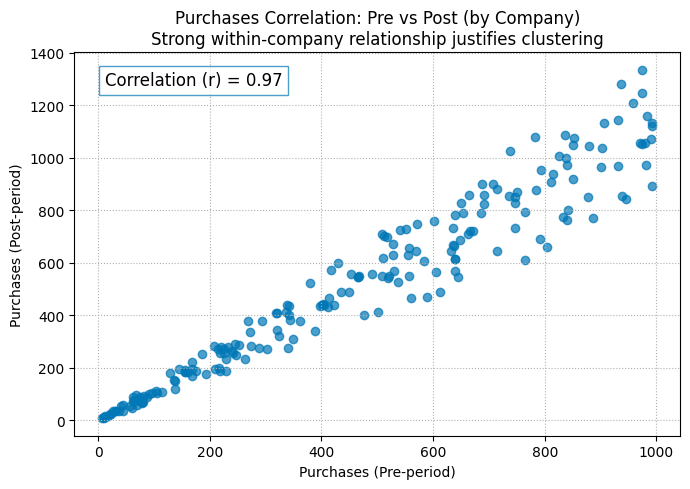

In [ ]:
"""
This script first compares the impact of using clustered vs. unclustered
standard errors in a Difference-in-Differences (DiD) analysis. It then
visualizes the strong within-company correlation of purchases between the
pre and post periods, which justifies the need for clustering.
"""

# === 1. IMPORTS AND DATA LOADING ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

# Load your data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# === 2. DID ANALYSIS: CLUSTERED VS. UNCLUSTERED STANDARD ERRORS ===

print("="*60)
print("DiD Impact of 15% Promo: Clustered vs. Unclustered SE")
print("="*60)

# --- Prepare data for regression ---
# Create dummy variables required for the DiD regression model.
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']  # The interaction term captures the DiD effect

# --- Model 1: Robust, Clustered Standard Errors ---
# This is the correct approach for this data because observations for the same
# company are correlated over time. Clustering adjusts for this.
model_clustered = smf.ols('Purchases ~ treated + post + did', data=df)
results_clustered = model_clustered.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})

did_coef_c = results_clustered.params['did']
se_c = results_clustered.bse['did']
pval_c = results_clustered.pvalues['did']

# --- Model 2: Standard, Unclustered Standard Errors ---
# This model incorrectly assumes all observations are independent. It typically
# leads to standard errors that are too small, making results seem more
# significant than they actually are.
model_unclustered = smf.ols('Purchases ~ treated + post + did', data=df)
results_unclustered = model_unclustered.fit()

did_coef_u = results_unclustered.params['did']
se_u = results_unclustered.bse['did']
pval_u = results_unclustered.pvalues['did']

# --- Create and Print Comparison Table ---
comparison_data = {
    'Standard Error Method': ['Clustered (Robust)', 'Unclustered (Standard)'],
    'DiD Coefficient': [did_coef_c, did_coef_u],
    'Standard Error (SE)': [se_c, se_u],
    'p-value': [pval_c, pval_u]
}
comparison_df = pd.DataFrame(comparison_data)

# Formatting for presentation
comparison_df['DiD Coefficient'] = comparison_df['DiD Coefficient'].map('{:.3f}'.format)
comparison_df['Standard Error (SE)'] = comparison_df['Standard Error (SE)'].map('{:.3f}'.format)
comparison_df['p-value'] = comparison_df['p-value'].map(lambda p: f"{p:.3f}" if p > 0.001 else "<0.001")

print(comparison_df.to_string(index=False))
print("\nNote: The DiD coefficient is the same, but the standard error is much larger")
print("and more appropriate when clustering is applied.\n")


# === 3. VISUALIZATION: PURCHASE CORRELATION ===

# Get average purchases per company in Pre and Post for each company (Test+Control)
pre = df[df['Period'] == 'Pre'].groupby('Company ID')['Purchases'].mean()
post = df[df['Period'] == 'Post'].groupby('Company ID')['Purchases'].mean()
merged = pd.DataFrame({'Pre': pre, 'Post': post}).dropna()  # only companies with both periods

# Calculate correlation
corr = merged['Pre'].corr(merged['Post'])

# Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(merged['Pre'], merged['Post'], alpha=0.7, color="#0077b6")
plt.title("Purchases Correlation: Pre vs Post (by Company)\nStrong within-company relationship justifies clustering")
plt.xlabel("Purchases (Pre-period)")
plt.ylabel("Purchases (Post-period)")
plt.grid(True, linestyle=':')
plt.text(
    0.05, 0.95, f"Correlation (r) = {corr:.2f}",
    ha='left', va='top', transform=plt.gca().transAxes,
    fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='#0077b6')
)
plt.tight_layout()
plt.show()

# **Sensitivity Analysis on Predicted 25% Promotion Impact (Purchases)**

🚀 Starting Promotion Impact and Elasticity Analysis...

📈 Net Revenue per Company-Period for Each Scenario (DiD Adjusted)
Baseline:            9,270.72
15% Promo (Observed): 9,545.55 (Change: +274.83)
25% Promo (Worst):   9,319.30 (Change: +48.58)
25% Promo (Likely):  9,888.70 (Change: +617.98)
25% Promo (Best):    10,472.73 (Change: +1,202.01)


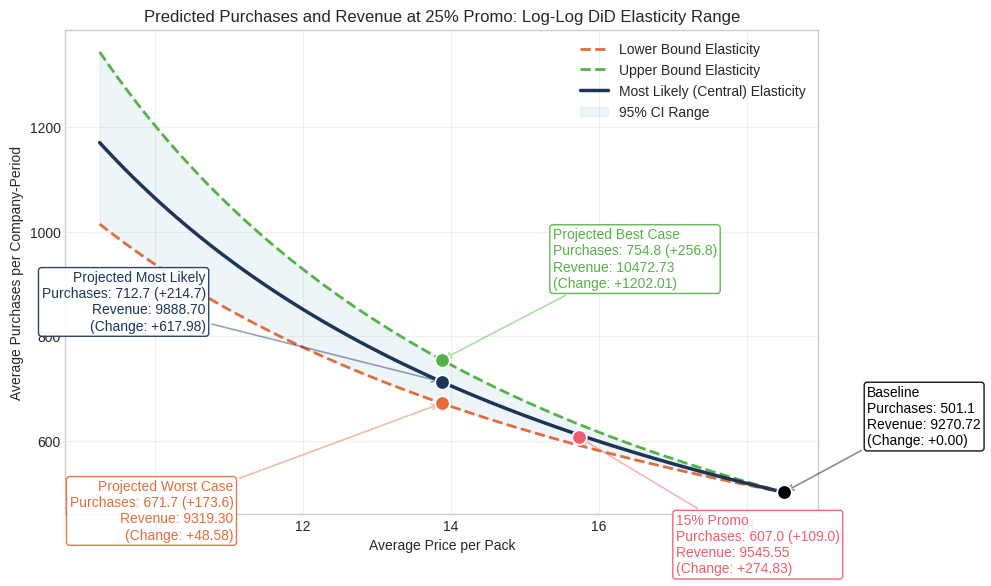


Analysis complete. ✨


In [36]:
# -*- coding: utf-8 -*-
"""
This script analyzes the impact of a price promotion on purchases using a
Difference-in-Differences (DiD) approach. It calculates the price elasticity
derived from the DiD model and uses its confidence interval to project a range
of potential outcomes (worst, likely, best) for a new, larger promotion.

The key steps are:
1.  Run a DiD regression with clustered standard errors to find the causal
    impact of the 15% promotion.
2.  Derive the central, lower, and upper bounds of price elasticity based on the
    DiD coefficient and its 95% confidence interval.
3.  Project the expected purchases and revenue for a hypothetical 25% promotion
    under each elasticity scenario using a true DiD calculation.
4.  Visualize the demand curves and projected outcomes in a comprehensive plot.
"""

# === 1. IMPORTS AND CONFIGURATION ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# --- Configuration ---
FILE_PATH: str = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
CLUSTER_ID: str = 'Company ID'
OUTCOME_VAR: str = 'Purchases'
PRICE_VAR: str = 'Promotion Pack Price'

# === 2. DATA LOADING AND PREPARATION ===

def load_and_prepare_data(file_path: str) -> pd.DataFrame:
    """
    Loads data and creates necessary dummy variables for DiD analysis.

    Args:
        file_path (str): The path to the input Excel file.

    Returns:
        pd.DataFrame: The prepared DataFrame for analysis.
    """
    df = pd.read_excel(file_path)
    df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
    df['post'] = (df['Period'] == 'Post').astype(int)
    df['did'] = df['treated'] * df['post']
    return df

# === 3. CORE ANALYSIS: DID AND ELASTICITY CALCULATION ===

def run_did_analysis(df: pd.DataFrame) -> dict[str, float]:
    """
    Performs a DiD regression with clustered standard errors.

    Args:
        df (pd.DataFrame): The prepared DataFrame.

    Returns:
        Dict[str, float]: A dictionary with the central, low, and high DiD coefficients.
    """
    # Clustering by Company ID is crucial as multiple observations for the same
    # company are not independent. This provides more robust standard errors.
    model = smf.ols(f'{OUTCOME_VAR} ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df[CLUSTER_ID]})

    did_coef = result.params['did']
    ci_low, ci_high = result.conf_int().loc['did']

    return {'central': did_coef, 'low': ci_low, 'high': ci_high}

def calculate_elasticity_from_did(df: pd.DataFrame, did_effect: float) -> float:
    """
    Derives the log-log price elasticity from a given DiD coefficient.
    This method isolates the elasticity attributable to the promotion by
    adjusting for the underlying trend observed in the control group.

    Args:
        df (pd.DataFrame): The prepared DataFrame.
        did_effect (float): The DiD coefficient (causal impact on purchases).

    Returns:
        float: The calculated log-log DiD price elasticity.
    """
    # Calculate group means needed for the elasticity formula
    test_pre = df[(df['treated'] == 1) & (df['post'] == 0)]
    test_post = df[(df['treated'] == 1) & (df['post'] == 1)]
    ctrl_pre = df[(df['treated'] == 0) & (df['post'] == 0)]
    ctrl_post = df[(df['treated'] == 0) & (df['post'] == 1)]

    avg_purchases_baseline = test_pre[OUTCOME_VAR].mean()
    avg_price_baseline = test_pre[PRICE_VAR].mean()
    avg_price_15 = test_post[PRICE_VAR].mean()
    ctrl_pre_mean = ctrl_pre[OUTCOME_VAR].mean()
    ctrl_post_mean = ctrl_post[OUTCOME_VAR].mean()

    # To calculate the elasticity, we first need to determine what the test group's
    # purchases *would have been* with the DiD effect, holding other factors constant.
    control_delta = ctrl_post_mean - ctrl_pre_mean
    adj_test_post = avg_purchases_baseline + control_delta + did_effect

    # Ensure values are valid for log calculation
    if not all(val > 0 for val in [avg_purchases_baseline, adj_test_post, ctrl_pre_mean, ctrl_post_mean]):
        return np.nan

    # Calculate elasticity: (% change in quantity) / (% change in price)
    log_trend_test = np.log(adj_test_post / avg_purchases_baseline)
    log_trend_ctrl = np.log(ctrl_post_mean / ctrl_pre_mean)
    log_trend_did = log_trend_test - log_trend_ctrl # Isolates promo effect on quantity

    pct_price_change_log = np.log(avg_price_15 / avg_price_baseline)

    return log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan

# === 4. PROJECTIONS AND VISUALIZATION ===

def generate_projections_and_plot(df: pd.DataFrame, did_results: dict[str, float]):
    """
    Calculates DiD-adjusted projections for a 25% promo and creates the final visualization.

    Args:
        df (pd.DataFrame): The prepared DataFrame.
        did_results (Dict[str, float]): The dictionary of DiD results.
    """
    # --- Calculate Elasticities ---
    elasticity_central = calculate_elasticity_from_did(df, did_results['central'])
    elasticity_low = calculate_elasticity_from_did(df, did_results['low'])
    elasticity_high = calculate_elasticity_from_did(df, did_results['high'])

    # --- Calculate Scenario Values ---
    test_pre = df[(df['treated'] == 1) & (df['post'] == 0)]
    test_post = df[(df['treated'] == 1) & (df['post'] == 1)]
    ctrl_pre = df[(df['treated'] == 0) & (df['post'] == 0)]
    ctrl_post = df[(df['treated'] == 0) & (df['post'] == 1)]

    avg_price_baseline = test_pre[PRICE_VAR].mean()
    avg_purchases_baseline = test_pre[OUTCOME_VAR].mean()
    avg_price_15 = test_post[PRICE_VAR].mean()
    avg_purchases_15 = test_post[OUTCOME_VAR].mean()
    avg_price_25 = avg_price_baseline * 0.75

    control_trend = ctrl_post[OUTCOME_VAR].mean() - ctrl_pre[OUTCOME_VAR].mean()

    # --- Corrected DiD Projections ---
    def project_did_purchases(elasticity):
        projected_purchases_simple = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity
        did_effect_25 = (projected_purchases_simple - avg_purchases_baseline) - control_trend
        final_purchases = avg_purchases_baseline + control_trend + did_effect_25
        return final_purchases, did_effect_25

    y_25_central, did_25_central = project_did_purchases(elasticity_central)
    y_25_low, did_25_low = project_did_purchases(elasticity_low)
    y_25_high, did_25_high = project_did_purchases(elasticity_high)

    # --- Calculate Revenues and Print Summary ---
    revenue_baseline = avg_price_baseline * avg_purchases_baseline
    revenue_15 = avg_price_15 * avg_purchases_15
    revenue_25_central = avg_price_25 * y_25_central
    revenue_25_low = avg_price_25 * y_25_low
    revenue_25_high = avg_price_25 * y_25_high

    print("\n" + "="*60)
    print("📈 Net Revenue per Company-Period for Each Scenario (DiD Adjusted)")
    print("="*60)
    print(f"{'Baseline:':<20} {revenue_baseline:,.2f}")
    print(f"{'15% Promo (Observed):':<20} {revenue_15:,.2f} (Change: {revenue_15 - revenue_baseline:+,.2f})")
    print(f"{'25% Promo (Worst):':<20} {revenue_25_low:,.2f} (Change: {revenue_25_low - revenue_baseline:+,.2f})")
    print(f"{'25% Promo (Likely):':<20} {revenue_25_central:,.2f} (Change: {revenue_25_central - revenue_baseline:+,.2f})")
    print(f"{'25% Promo (Best):':<20} {revenue_25_high:,.2f} (Change: {revenue_25_high - revenue_baseline:+,.2f})")

    # --- Plotting (Replicating Original Style) ---
    plt.figure(figsize=(10, 6))

    prices_domain = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
    def demand_curve(elasticity):
        return avg_purchases_baseline * (prices_domain / avg_price_baseline) ** elasticity

    plt.plot(prices_domain, demand_curve(elasticity_low), color='#E36C3B', linestyle='--', linewidth=2, label='Lower Bound Elasticity')
    plt.plot(prices_domain, demand_curve(elasticity_high), color='#54B345', linestyle='--', linewidth=2, label='Upper Bound Elasticity')
    plt.plot(prices_domain, demand_curve(elasticity_central), color='#1D3557', linewidth=2.5, label='Most Likely (Central) Elasticity')
    plt.fill_between(prices_domain, demand_curve(elasticity_low), demand_curve(elasticity_high), color='#A6CEE3', alpha=0.2, label='95% CI Range')

    # Define points and annotation text with corrected DiD impacts
    points = [
        {'px': avg_price_baseline, 'py': avg_purchases_baseline, 'color': 'black',
         'text': f"Baseline\nPurchases: {avg_purchases_baseline:.1f}\nRevenue: {revenue_baseline:.2f}\n(Change: +0.00)"},
        {'px': avg_price_15, 'py': avg_purchases_15, 'color': '#EE5D6C',
         'text': f"15% Promo\nPurchases: {avg_purchases_15:.1f} (+{did_results['central']:.1f})\nRevenue: {revenue_15:.2f}\n(Change: {revenue_15 - revenue_baseline:+.2f})"},
        {'px': avg_price_25, 'py': y_25_central, 'color': '#1D3557',
         'text': f"Projected Most Likely\nPurchases: {y_25_central:.1f} (+{did_25_central:.1f})\nRevenue: {revenue_25_central:.2f}\n(Change: {revenue_25_central - revenue_baseline:+.2f})"},
        {'px': avg_price_25, 'py': y_25_low, 'color': '#E36C3B',
         'text': f"Projected Worst Case\nPurchases: {y_25_low:.1f} (+{did_25_low:.1f})\nRevenue: {revenue_25_low:.2f}\n(Change: {revenue_25_low - revenue_baseline:+.2f})"},
        {'px': avg_price_25, 'py': y_25_high, 'color': '#54B345',
         'text': f"Projected Best Case\nPurchases: {y_25_high:.1f} (+{did_25_high:.1f})\nRevenue: {revenue_25_high:.2f}\n(Change: {revenue_25_high - revenue_baseline:+.2f})"},
    ]

    # Use exact annotation positions from original script
    label_positions = [
        {'xytext': (60, 32), 'ha': 'left', 'va': 'bottom'},
        {'xytext': (70, -55), 'ha': 'left', 'va': 'top'},
        {'xytext': (-170, 35), 'ha': 'right', 'va': 'bottom'},
        {'xytext': (-150, -55), 'ha': 'right', 'va': 'top'},
        {'xytext': (80, 50), 'ha': 'left', 'va': 'bottom'},
    ]

    for point, annopos in zip(points, label_positions):
        plt.scatter(point['px'], point['py'], color=point['color'], s=110, zorder=6, edgecolor='white', linewidth=1.3)
        plt.annotate(
            point['text'], (point['px'], point['py']),
            textcoords='offset points',
            xytext=annopos['xytext'], ha=annopos['ha'], va=annopos['va'],
            color=point['color'], fontsize=10,
            bbox=dict(boxstyle="round,pad=0.22", fc="white", ec=point['color'], alpha=0.92),
            arrowprops=dict(arrowstyle='->', lw=1.2, color=point['color'], alpha=0.46)
        )

    plt.xlabel('Average Price per Pack')
    plt.ylabel('Average Purchases per Company-Period')
    plt.title('Predicted Purchases and Revenue at 25% Promo: Log-Log DiD Elasticity Range')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === 5. MAIN EXECUTION BLOCK ===

def main():
    """
    Main function to orchestrate the analysis.
    """
    print("🚀 Starting Promotion Impact and Elasticity Analysis...")
    # Load and prepare data
    data = load_and_prepare_data(FILE_PATH)
    if data.empty:
        return

    # Run core analyses
    did_results = run_did_analysis(data)

    # Generate projections and visualization
    generate_projections_and_plot(data, did_results)

    print("\nAnalysis complete. ✨")


if __name__ == '__main__':
    main()